# Criterion 1 Terror Attack
The violent act must be aimed at attaining a political, economic, religious, or social goal. 
This criterion is not satisfied in those cases where the perpetrator(s) acted out of a pure profit motive or from an idiosyncratic personal motive unconnected with broader societal change. 

## Null Hypothesis
On average, equal number of successful `Criterion 1` terror attacks happen in India and United States per year.


In [1]:
import pandas as pd
import pandasql as pdsql
import seaborn as sns
import matplotlib.pyplot as plt
import scipy

import scipy.stats as stats
from IPython.display import display

In [2]:
dataset = pd.read_csv("../Raw Data/globalterrorismdb_0718dist.csv", encoding="ISO-8859-1", low_memory=False)
india_pde_dataset = pd.read_csv("../Raw Data/population_density_india.csv")
usa_pde_dataset = pd.read_csv("../Raw Data/population_density_usa.csv")

In [3]:
dataset.head()

,eventid,iyear,imonth,iday,approxdate,extended,resolution,country,country_txt,region,...,addnotes,scite1,scite2,scite3,dbsource,INT_LOG,INT_IDEO,INT_MISC,INT_ANY,related
0,197000000001,1970,7,2,NaN,0,NaN,58,Dominican Republic,2,...,NaN,NaN,NaN,NaN,PGIS,0,0,0,0,NaN
1,197000000002,1970,0,0,NaN,0,NaN,130,Mexico,1,...,NaN,NaN,NaN,NaN,PGIS,0,1,1,1,NaN
2,197001000001,1970,1,0,NaN,0,NaN,160,Philippines,5,...,NaN,NaN,NaN,NaN,PGIS,-9,-9,1,1,NaN
3,197001000002,1970,1,0,NaN,0,NaN,78,Greece,8,...,NaN,NaN,NaN,NaN,PGIS,-9,-9,1,1,NaN
4,197001000003,1970,1,0,NaN,0,NaN,101,Japan,4,...,NaN,NaN,NaN,NaN,PGIS,-9,-9,1,1,NaN


### Important assumptions and points
1. It is assumed that the data collected is not biased towards any country / government organization.
2. The attacks happened in both the countries are independent towards each other.
3. Since the population density in both the countries is different, it is possible that biasness is created. Hence we will conduct an analysis where we will consider number of cases in both the countries per year per population density.

In [4]:
query = """
    select 
        iyear, 
        sum(
            case
                when country_txt = "United States" then 1 else 0
            end
        ) as usa_cases, 
        sum(
            case
                when country_txt = "India" then 1 else 0
            end
        ) as ind_cases
    from dataset 
    where country_txt IN ("United States", "India") and success=1
    group by iyear
    having usa_cases > 0 and ind_cases > 0
"""
data = pdsql.sqldf(query)

In [5]:
display(data.head())
display(data.describe())

,iyear,usa_cases,ind_cases
0,1972,48,1
1,1975,136,1
2,1976,88,1
3,1977,95,1
4,1979,54,19


,iyear,usa_cases,ind_cases
count,42.000000,42.000000,42.000000
mean,1995.928571,36.452381,244.761905
std,12.939621,26.137724,233.729133
min,1972.000000,4.000000,1.000000
25%,1985.250000,21.250000,68.500000
50%,1996.500000,29.000000,170.000000
75%,2006.750000,51.000000,335.500000
max,2017.000000,136.000000,786.000000


[Text(0.5, 0, 'Year'), Text(0, 0.5, 'Number of Cases'), Text(0.5, 1.0, 'USA')]

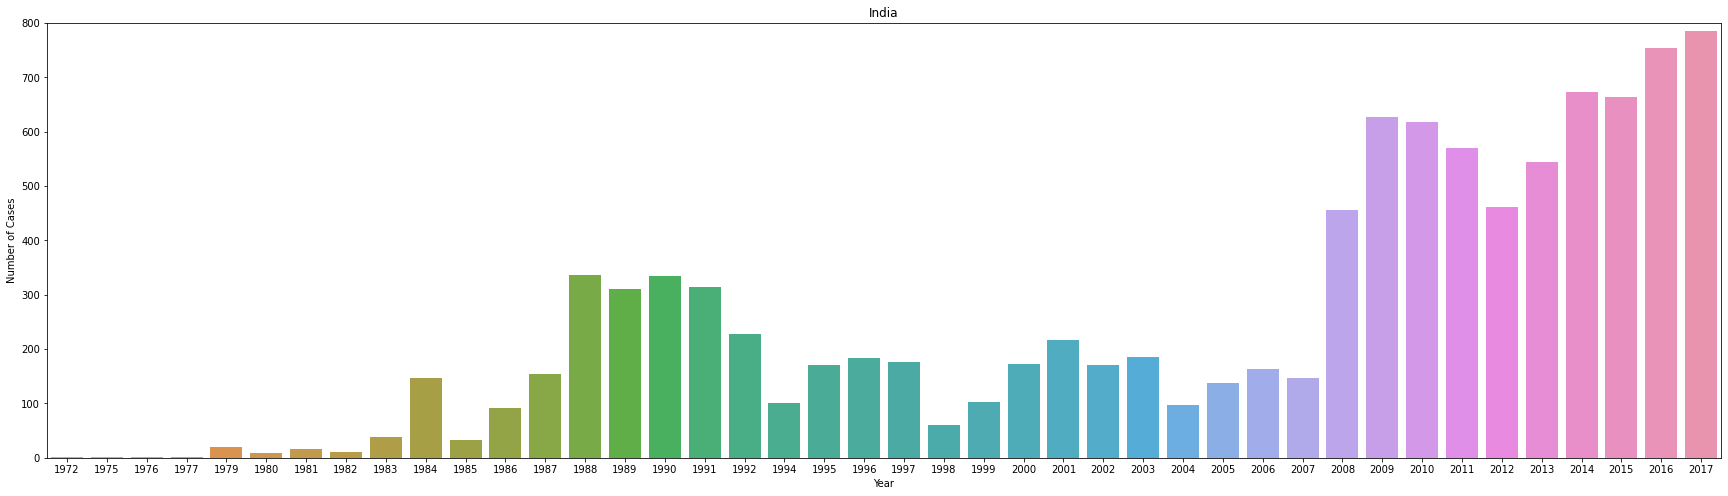

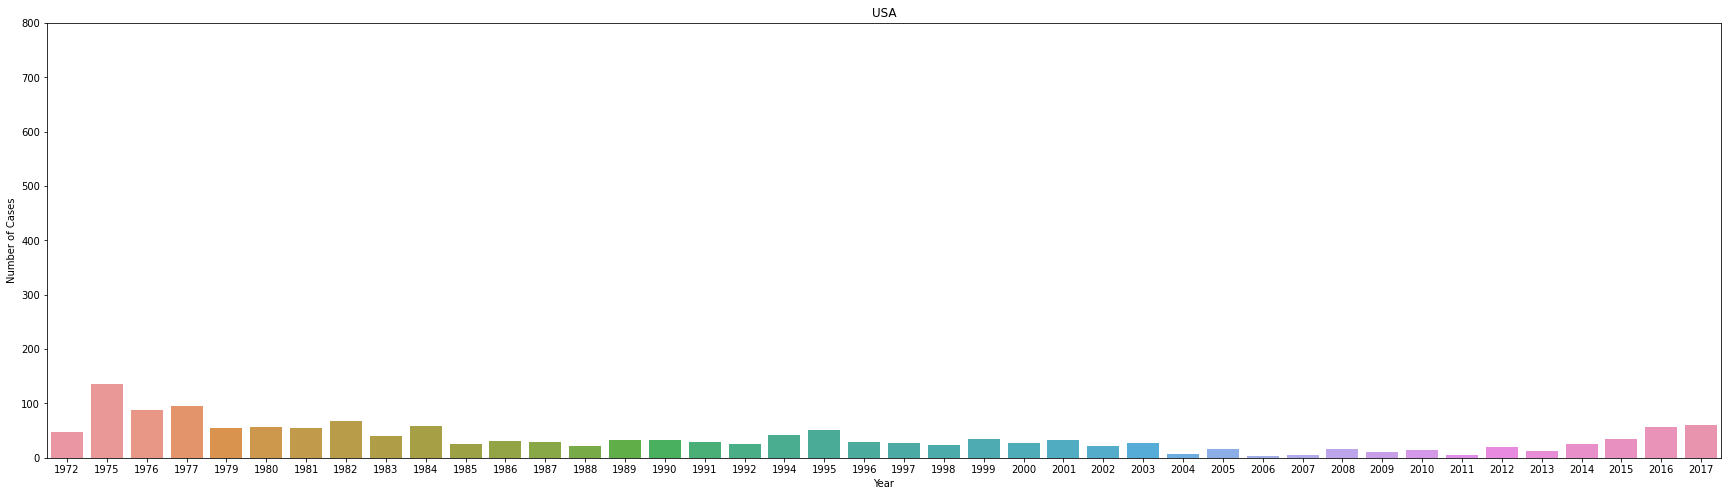

In [6]:
_, ax1 = plt.subplots(figsize=(30, 8))
_, ax2 = plt.subplots(figsize=(30, 8))
ind_plot = sns.barplot(x='iyear', y='ind_cases', data=data, ax=ax1)
ind_plot.set(ylim=(0, 800))
ind_plot.set(xlabel='Year', ylabel='Number of Cases', title='India')
usa_plot = sns.barplot(x='iyear', y='usa_cases', data=data, ax=ax2)
usa_plot.set(ylim=(0, 800))
usa_plot.set(xlabel='Year', ylabel='Number of Cases', title='USA')

From the plot we can see that Indian cases on average are more but we <b>cannot</b> conclude this because of many other factors that may be contributing to this.
One of which is that the Indian population is more as compared to U.S. 
Hence, let's visualize the results by normalizing the data by using the population density of both the countries per year.

## Hypothesis validation 
We will now validate the hypothesis by normalizing the data using population density.
Hence, we will assume that the biasness of the data gets removed to a large extent when we normalize.

In [7]:
query = """
    select 
        iyear as year, 
        usa_cases / US.pdensity as usa_cases_per_pde, 
        ind_cases / IND.pdensity as ind_cases_per_pde
    from data
    inner join india_pde_dataset IND
        on IND.Year = data.iyear
    inner join usa_pde_dataset US
        on US.Year = data.iyear
"""
density_data = pdsql.sqldf(query)

In [8]:
density_data.head()

,year,usa_cases_per_pde,ind_cases_per_pde
0,1972,2.213001,0.005657
1,1975,6.104129,0.005276
2,1976,3.912850,0.005155
3,1977,4.185022,0.005039
4,1979,2.335640,0.091447


[Text(0.5, 0, 'Year'),
 Text(0, 0.5, 'Number of Cases Per Population Density'),
 Text(0.5, 1.0, 'USA')]

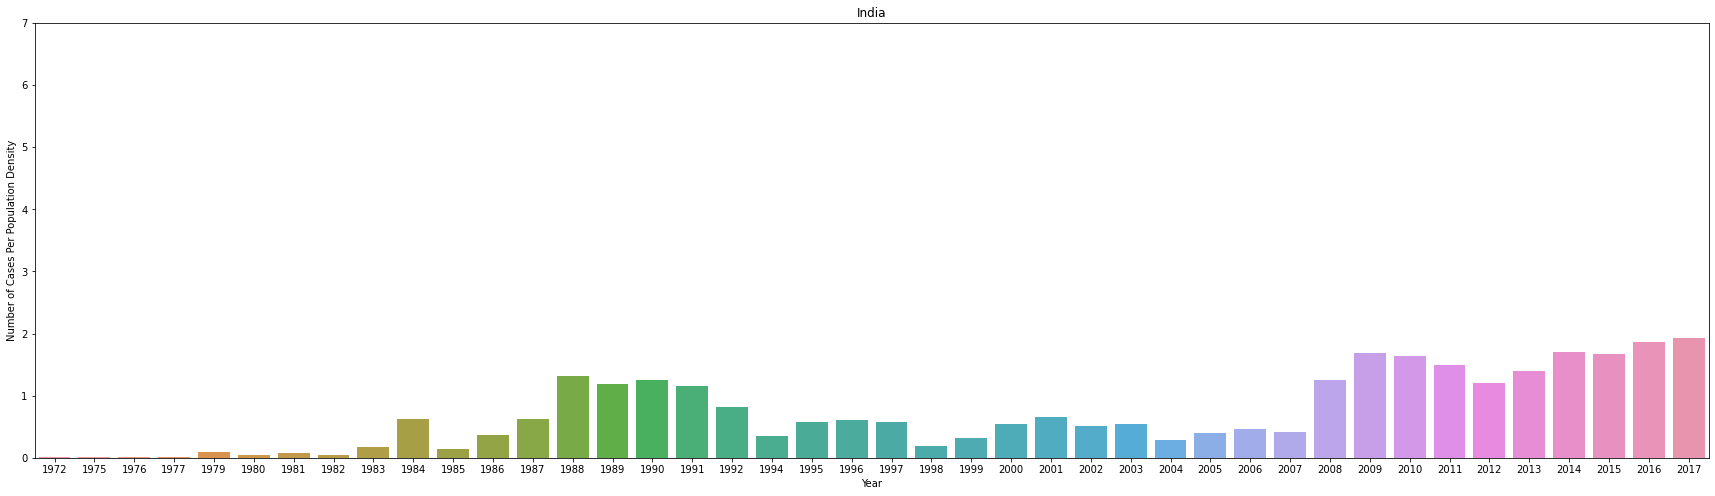

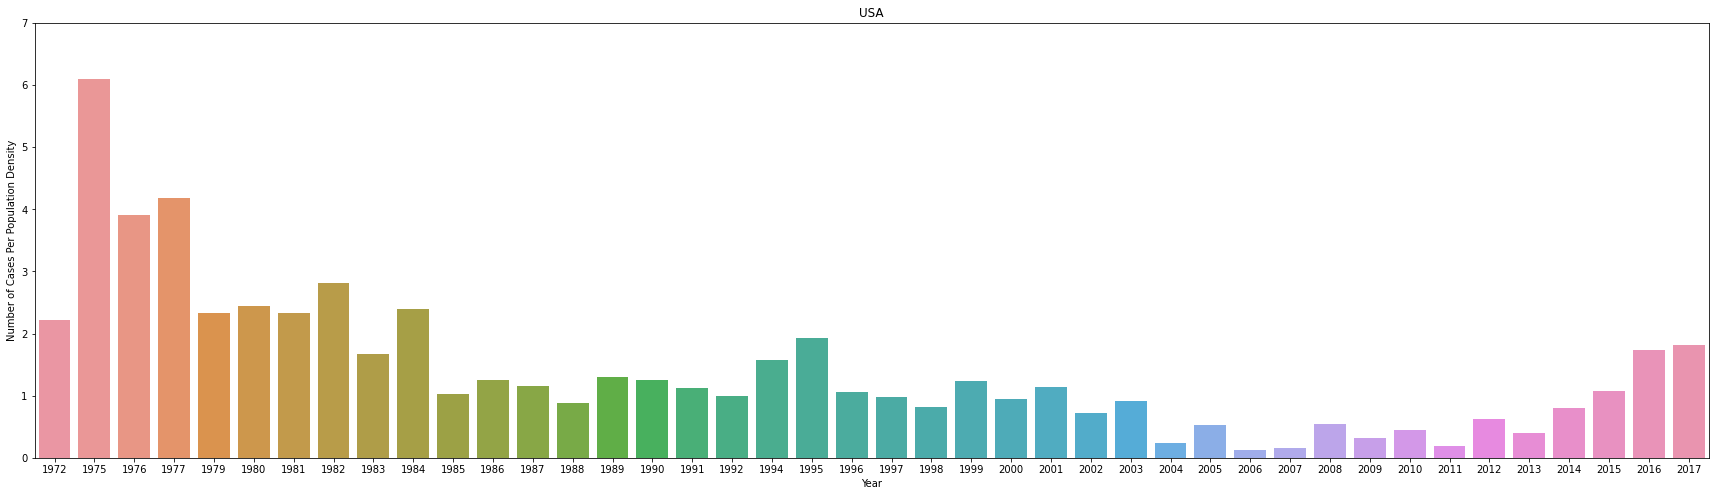

In [9]:
_, ax1 = plt.subplots(figsize=(30, 8))
_, ax2 = plt.subplots(figsize=(30, 8))
ind_plot = sns.barplot(x='year', y='ind_cases_per_pde', data=density_data, ax=ax1)
ind_plot.set(ylim=(0, 7))
ind_plot.set(xlabel='Year', ylabel='Number of Cases Per Population Density', title='India')
usa_plot = sns.barplot(x='year', y='usa_cases_per_pde', data=density_data, ax=ax2)
usa_plot.set(ylim=(0, 7))
usa_plot.set(xlabel='Year', ylabel='Number of Cases Per Population Density', title='USA')

In [10]:
density_data.drop(['year'], axis=1).describe()

,usa_cases_per_pde,ind_cases_per_pde
count,42.000000,42.000000
mean,1.421964,0.720405
std,1.182182,0.601380
min,0.132057,0.005039
25%,0.739570,0.218814
50%,1.096214,0.562581
75%,1.794408,1.235649
max,6.104129,1.930113


Let's test our hypothesis by conducting a hypothesis test caled ANOVA

### Analysis of Variance (ANOVA)
Analysis of Variance, shortly known as ANOVA is an extremely important tool for analysis of data. It is a statistical method to compare the population means of two or more groups by analyzing variance. The variance would differ only when the means are significantly different.

It is a generalized method of t-test for more than 2 groups but is more conservative, i.e. results in less type 1 error, and hence suited to a wide range of practical applications.

Let there be two samples, `Sample A` and `Sample B` where the total data points in both samples are $ n_a $ and $ n_b $ respectively.

Let the mean of `Sample A` be $ \bar{X}_a $ and the same for `Sample B` be $ \bar{X}_b $.

#### Define Null Hypothesis
Null Hypothesis: $ \bar{X}_a = \bar{X}_b $

#### Define significance level
Let our level of confidence be equal to 95 %

$ \therefore \alpha = 0.05 $

#### Calculation of the grand mean
Let the Grand Mean of the two samples be $ \bar{X}_{GM} $.

$ X_{gm} = \frac{\bar{X}_a * n_a + \bar{X}_b * n_b}{n_a + n_b} $

#### Calculation of degrees of freedom
$ df_{between} = 2 - 1 = 1 $

$ df_{within} = n_a + n_b - 2 = 42 + 42 - 2 = 82 $

#### Determination of critical F statistic
The $ F_{critical} $ value can be calculated using the `F table` or from this source https://www.socscistatistics.com/tests/criticalvalues/default.aspx

Significance Level $ \alpha $: 0.05

Degrees of Freedom (Numerator): $ df_{between} $

Degrees of Freedom (Denominator): $ df_{within} $

$ \therefore F_{critical} = 3.957 $
#### Calculation of sum of squares
$ SS_{total} = \sum {(X_i - X_{GM}) ^ 2} $ where $ X_i $ is all the possible values in the two samples

$ SS_{within} = \sum \limits _{i=1} ^ {n_a}{(X_i - \bar{X}_{a}) ^ 2} + \sum \limits _{j=1} ^ {n_b}{(X_j - \bar{X}_{b}) ^ 2}$

We know that $ SS_{total} = SS_{between} + SS_{within} $

$ \therefore SS_{between} = SS_{total} - SS_{within}$

#### Calculation of mean squares
$ MS_{within} = \frac{SS_{within}}{df_{within}} $

$ MS_{between} = \frac{SS_{between}}{df_{between}} $

#### Calculation of F statistic of dataset
$ F = \frac{MS_{between}}{MS_{within}} $

#### Result interpretation
If $ F > F_{critical} $, then we reject the null hypothesis.

Else, we fail to reject the null

In [11]:
fcrit  = scipy.stats.f.ppf(q=1-0.05, dfn=1, dfd=82)
fvalue, pvalue = stats.f_oneway(density_data['ind_cases_per_pde'], density_data['usa_cases_per_pde'])
print(f'Critical F value: {fcrit}')
print(f'Obtained F value: {fvalue}')
print(f'Obtained P value: {pvalue}')

Critical F value: 3.9573883217679424
Obtained F value: 11.750608480607152
Obtained P value: 0.0009537103492031754


#### Conclusion on the basis of ANOVA
We assumed that no bias gets created after we normalize the data using population density of both the countries.

Since, $ F > F_{critical} $

$ \therefore $ <b>We reject the null hypothesis</b>

To be very sure on the conclusion we made, let's perform a two-tailed t-test.

### Student's t-test
A `t-test` uses something called a `t-statistic`. 
A `t-statistic` is a standardized value that is calculated from sample data during a hypothesis test.

Let there be two samples, `Sample A` and `Sample B` where the total data points in both samples are $ n_a $ and $ n_b $ respectively.

Let the mean of `Sample A` be $ \bar{X}_a $ and the same for `Sample B` be $ \bar{X}_b $.

#### Define Null Hypothesis
Null Hypothesis: $ \bar{X}_a = \bar{X}_b $

#### Define significance level
Let our level of confidence be equal to 95 %

$ \therefore \alpha = 0.05 $

#### Calculation of the t-statistic
$ t = \frac{(\bar{X}_a - \bar{X}_b) - \delta}{\frac{s_a ^ 2}{n_a} + \frac{s_b ^ 2}{n_b}} $

Where,

$ \delta $: Hypothesized difference between the sample means (0 if testing for equal means).

$ s_i ^ 2 $: Standard deviation of the $i^{th}$ sample.

#### Calculation of degrees of freedom
$ df =  \frac{\frac{s_a ^ 2}{n_a} + \frac{s_b ^ 2}{n_b}}{\frac{(s_a ^ 2 / n_a ) ^ 2}{n_a - 1} + \frac{(s_b ^ 2 / n_b ) ^ 2}{n_b - 1}} $

#### Calculation of p value and result interpretation
P value can be calculated by looking at the `t-table` or by this source https://www.socscistatistics.com/pvalues/tdistribution.aspx

If $ p < \alpha $, then we reject the null hypothesis.

Else, we fail to reject the null.

In [13]:
ind_mean = density_data['ind_cases_per_pde'].mean()
ind_std = density_data['ind_cases_per_pde'].std()
usa_mean = density_data['usa_cases_per_pde'].mean()
usa_std = density_data['usa_cases_per_pde'].std()

def degrees_of_freedom(s1, n1, s2, n2):
    return n1 + n2 - 2
    numerator = s1 ** 2 / n1 + s2 ** 2 / n2
    denominator = (s1 ** 2 / n1) ** 2 / (n1 - 1) + (s2 ** 2 / n2) ** 2 / (n2 - 1)
    return int(round(numerator / denominator))

def t_value(x1, x2, s1, s2, n1, n2, delta):
    numerator = (x1 - x2) - delta
    denominator = s1 ** 2 / n1 + s2 ** 2 / n2
    return numerator / denominator
    
dof = degrees_of_freedom(ind_std, 42, usa_std, 42)
tvalue = t_value(ind_mean, usa_mean, ind_std, usa_std, 42, 42, 0)
pvalue = stats.t.sf(abs(tvalue), df=dof) * 2
print(f'Degrees of freedom:    {dof}')
print(f'Obtained t statistic:  {tvalue}')
print(f'Obtained p value:      {pvalue}')

Degrees of freedom:    82
Obtained t statistic:  -16.749262406855987
Obtained p value:      3.394491291986574e-28


#### Conclusion on the basis of a t-test
We can see that $ p_{val} ≈ 0 $ i.e. $ p_{val} << \alpha $

$ \therefore $ <b>We reject the null hypothesis</b>.

### Final conclusion
For our assumption that normalizing the data using population density reduces the bias of events happening, we have gathered enough evidence that supports our alternate hypothesis i.e $ \mu_{india} \not= \mu_{usa}$.

$ \therefore $ <b>We reject the null hypothesis</b>.

And hence, we conclude that on average, the number of `Criterion 1` terror attacks happen in India and United States per year are <b>not</b> equal.